CONVNET FOR CIFAR 10 TO CLASSIFY IMAGES WITH DATA AUGMENTED 

In [1]:
from __future__ import absolute_import
import os
import random
import numpy as np
from keras.layers import *
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


In [2]:
 
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)


In [3]:

!pip install tensorflow==1.15


     |████████████████████████████████| 412.3 MB 21 kB/s s eta 0:00:01     |████████████████▌               | 213.0 MB 56.5 MB/s eta 0:00:04     |███████████████████████▉        | 306.4 MB 51.7 MB/s eta 0:00:03     |████████████████████████▍       | 314.0 MB 51.7 MB/s eta 0:00:02     |████████████████████████▋       | 317.3 MB 51.7 MB/s eta 0:00:02     |█████████████████████████▍      | 326.5 MB 74.8 MB/s eta 0:00:02
     |████████████████████████████████| 503 kB 32.5 MB/s eta 0:00:01
     |████████████████████████████████| 3.8 MB 42.0 MB/s eta 0:00:01
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.1.0
    Uninstalling tensorflow-estimator-2.1.0:
      Successfully uninstalled tensorflow-estimator-2.1.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.1.1
    Uninstalling tensorboard-2.1.1:
      Successfully uninstalled tensorboard-2.1.1
  Attempting uninstall: tensorflow
    Found existing install

In [4]:
import tensorflow as tf

In [5]:
tf.config.experimental.list_physical_devices(device_type=None) 

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU')]

In [6]:
from keras import backend as K
from keras.models import Sequential
from keras.layers import Lambda, Layer
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dense
from keras.datasets import cifar10 
from keras.utils import np_utils
from keras.constraints import maxnorm
from keras.optimizers import SGD
from keras.layers.core import Reshape
from keras.optimizers import SGD, RMSprop, Adam
from keras.layers.advanced_activations import LeakyReLU
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt

In [7]:
K.common.set_image_dim_ordering('tf')

MODEL

In [8]:
#define the ConvNet
class ConvNet:
    @staticmethod
    def build(input_shape,classes):
        model = Sequential()
        #BLOCK1
        model.add(Conv2D(16, (3, 3), padding='same',input_shape=input_shape))
        model.add(Activation('relu'))
        model.add(Conv2D(16, (3, 3), padding='same'))
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))
        #BLOCK2
        model.add(Conv2D(32, (3, 3), padding='same'))
        model.add(Activation('relu'))
        model.add(Conv2D(32, (3, 3)))
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))
        #BLOCK3
        model.add(Conv2D(64, (3, 3), padding='same'))
        model.add(Activation('relu'))
        model.add(Conv2D(64, (3, 3)))
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))
       
        
        # END BLOCK
        model.add(Flatten())
        model.add(Dense(512))
        model.add(Activation('relu'))
        model.add(Dropout(0.5))
        model.add(Dense(classes))
        model.add(Activation('softmax'))
        
        return model

DATASET CIFAR_10 is a set of 60K images 32x32 pixels on 3 channels

In [9]:
(X_ag, y_ag), (X_test, y_test) = cifar10.load_data()

170500096/170498071 [==============================] - 12s 0us/step


DATA GENERATION

In [10]:
NUM_TO_AUGMENT=5


In [11]:
# augumenting
print("Augmenting training set images...")
datagen = ImageDataGenerator(rotation_range=20,width_shift_range=0.2,height_shift_range=0.2,zoom_range=0.2,horizontal_flip=True,fill_mode='nearest') 

Augmenting training set images...


In [12]:
!rm -R '/kaggle/working/preview/'
!mkdir '/kaggle/working/preview'
os.listdir('/kaggle/working/preview')

rm: cannot remove '/kaggle/working/preview/': No such file or directory


[]

In [13]:
def data_augmentation(X,Y,rows,cols,chan):
      xtas, ytas =[],[]
      for i in range(X.shape[0]):
                num_aug = 0
                x = X[i] # (32, 32,3)
                y = Y[i]
                x = x.reshape((1,) + x.shape) # (1,32, 32,3)
                for x_aug,y_aug in datagen.flow(x, y,batch_size=1,save_to_dir='/kaggle/working/preview', save_prefix='cifar', save_format='jpeg'):
                                            if num_aug < NUM_TO_AUGMENT:
                                                    xx_aug=np.asarray(x_aug).reshape(rows,cols,chan)
                                                    yy_aug=np.asarray(y_aug)   
                                                    xtas.append(xx_aug)
                                                    ytas.append(yy_aug)
                                                    num_aug+=1
                                            else:
                                                 break
      xtas=np.asarray(xtas)
      ytas=np.asarray(ytas)
      return xtas,ytas

In [14]:
X_train,y_train=data_augmentation(X_ag,y_ag,32,32,3)

In [15]:
[[X_train.shape,y_train.shape],[X_ag.shape,y_ag.shape]]

[[(250000, 32, 32, 3), (250000, 1)], [(50000, 32, 32, 3), (50000, 1)]]

NORMALIZE

In [16]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

IMAGE FORMAT

In [17]:

# we need a 60K x [32*32*3] shape as input to the CONVNET

input_shape=(32,32,3)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

250000 train samples
10000 test samples


LABELS FROM CATEGORICAL TO NUMERICAL VALUES

In [18]:
nb_classes=10
class_names=['airplane','automobile','bird','cat','deer','dog','frog','horse','chip','truck']

In [19]:
# convert class vectors to binary class matrices
Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)


MODEL

In [20]:
model =ConvNet.build(input_shape,classes=nb_classes)

In [21]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 16)        448       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 16)        2320      
_________________________________________________________________
activation_2 (Activation)    (None, 32, 32, 16)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 16)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 32)       

In [22]:
#MODEL ARCHITECTURE
lr =0.0002


Loss Function

In [23]:
model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(lr),
              metrics=['accuracy'])


TRAINING

In [24]:
epochs = 72
BATCH_SIZE = 128

In [25]:
# simple early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)

In [26]:
history = model.fit(X_train, Y_train, batch_size=BATCH_SIZE,epochs=epochs,verbose=1, validation_split=0.2)

Train on 200000 samples, validate on 50000 samples
Epoch 1/72
200000/200000 [==============================] - 20s 99us/step - loss: 1.8533 - accuracy: 0.3008 - val_loss: 1.6361 - val_accuracy: 0.3972
Epoch 2/72
200000/200000 [==============================] - 15s 73us/step - loss: 1.6016 - accuracy: 0.4106 - val_loss: 1.5004 - val_accuracy: 0.4554
Epoch 3/72
200000/200000 [==============================] - 15s 75us/step - loss: 1.4926 - accuracy: 0.4562 - val_loss: 1.3879 - val_accuracy: 0.5004
Epoch 4/72
200000/200000 [==============================] - 15s 74us/step - loss: 1.4130 - accuracy: 0.4889 - val_loss: 1.3032 - val_accuracy: 0.5304
Epoch 5/72
200000/200000 [==============================] - 16s 78us/step - loss: 1.3531 - accuracy: 0.5144 - val_loss: 1.2556 - val_accuracy: 0.5472
Epoch 6/72
200000/200000 [==============================] - 15s 73us/step - loss: 1.3041 - accuracy: 0.5313 - val_loss: 1.1839 - val_accuracy: 0.5767
Epoch 7/72
200000/200000 [=======================

Epoch 55/72
200000/200000 [==============================] - 15s 74us/step - loss: 0.8129 - accuracy: 0.7153 - val_loss: 0.7388 - val_accuracy: 0.7405
Epoch 56/72
200000/200000 [==============================] - 15s 73us/step - loss: 0.8097 - accuracy: 0.7180 - val_loss: 0.7477 - val_accuracy: 0.7357
Epoch 57/72
200000/200000 [==============================] - 16s 79us/step - loss: 0.8065 - accuracy: 0.7186 - val_loss: 0.7510 - val_accuracy: 0.7358
Epoch 58/72
200000/200000 [==============================] - 15s 73us/step - loss: 0.8041 - accuracy: 0.7194 - val_loss: 0.7424 - val_accuracy: 0.7392
Epoch 59/72
200000/200000 [==============================] - 15s 74us/step - loss: 0.8016 - accuracy: 0.7206 - val_loss: 0.7334 - val_accuracy: 0.7431
Epoch 60/72
200000/200000 [==============================] - 15s 74us/step - loss: 0.7995 - accuracy: 0.7208 - val_loss: 0.7468 - val_accuracy: 0.7351
Epoch 61/72
200000/200000 [==============================] - 16s 78us/step - loss: 0.7965 - ac

In [27]:
# list all data in history
print(history.history.keys())

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


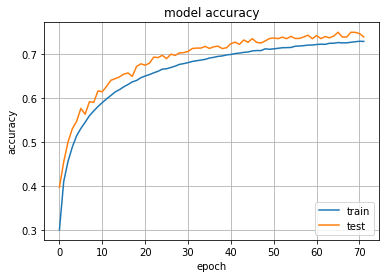

In [28]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.grid(True)
plt.show()

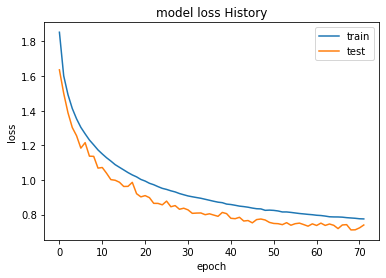

In [29]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss History')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

MODEL EVALUATION

In [30]:
score = model.evaluate(X_test, Y_test, verbose=1)
print('Test score:', score[0]*100)
print('Test accuracy:', score[1]*100)

10000/10000 [==============================] - 1s 113us/step
Test score: 82.35761503219604
Test accuracy: 71.90999984741211


MODEL PREDICTION

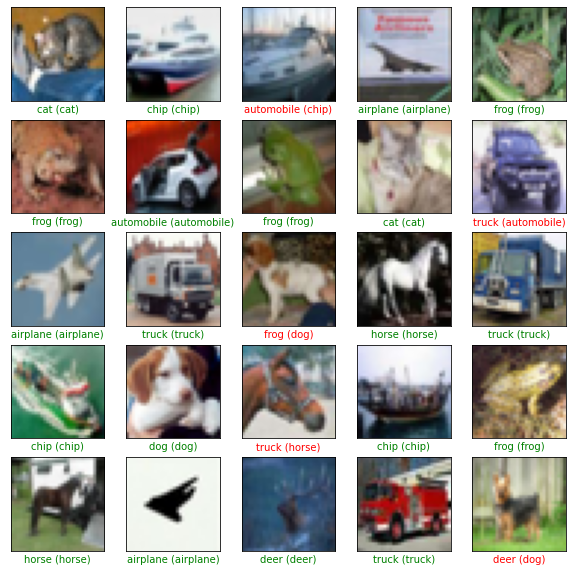

Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-31-122f1ea19953>", line 32, in <module>
    plt.savefig("/content/cifar10-comvnet.pdf")
  File "/opt/conda/lib/python3.7/site-packages/matplotlib/pyplot.py", line 723, in savefig
    res = fig.savefig(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/matplotlib/figure.py", line 2203, in savefig
    self.canvas.print_figure(fname, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/matplotlib/backend_bases.py", line 2105, in print_figure
    **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/matplotlib/backends/backend_pdf.py", line 2541, in print_pdf
    file = PdfFile(filename, metadata=metadata)
  File "/opt/conda/lib/python3.7/site-packages/matplotlib/backends/backend_pdf.py", line 459, in __init__
    fh, opened = cbook.to_filehandle(filename, 

FileNotFoundError: [Errno 2] No such file or directory: '/content/cifar10-comvnet.pdf'

<Figure size 432x288 with 0 Axes>

In [31]:
predictions = model.predict(X_test)
predicted_labels=model.predict_classes(X_test)
#print([predictions[0],predicted_labels[0]])


#max= np.argmax(predictions[0])
#print(max)

#tt=y_test[0]
#print(tt)

# Plot the first 25 test images, their predicted label, and the true label
# Color correct predictions in green, incorrect predictions in red
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid('False')
    plt.imshow(X_test[i], cmap=plt.cm.binary)
    #plt.imshow(X_test[i], interpolation='nearest')
    predicted_label = np.argmax(predictions[i])
    true_label = y_test[i][0]
    if predicted_label == true_label:
      color = 'green'
    else:
      color = 'red'
    plt.xlabel("{} ({})".format(class_names[predicted_label], 
                                  class_names[true_label]),
                                  color=color)
plt.show()
plt.savefig("/kaggle/working/cifar10-comvnet.pdf")

In [ ]:
print('Finish')

from PIL import Image
import numpy as np

w, h = 512, 512
data = np.zeros((h, w, 3), dtype=np.uint8)
data[0:256, 0:256] = [255, 0, 0] # red patch in upper left
img = Image.fromarray(data, 'RGB')
img.save('my.png')
img.show()

from scipy.misc import toimage
toimage(data).show()